In [37]:
import math
import logging
import time
import random
import sys
import argparse
import torch
import pandas as pd
import numpy as np

from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from module import TGAN
from graph import NeighborFinder
from utils import EarlyStopMonitor, RandEdgeSampler
from scipy.stats import spearmanr
import json
import matplotlib.pyplot as plt
from scipy.stats import kendalltau,pearsonr
from collections import defaultdict

### tgat test

In [3]:
e_feat = np.load('./processed/ml_{}.npy'.format('mini_wiki'))
n_feat = np.load('./processed/ml_{}_node.npy'.format('mini_wiki'))

In [4]:
def eval_one_epoch(hint, tgan, sampler, src, dst, ts, label):
    val_acc, val_ap, val_f1, val_auc = [], [], [], []
    with torch.no_grad():
        tgan = tgan.eval()
        TEST_BATCH_SIZE=30
        num_test_instance = len(src)
        num_test_batch = math.ceil(num_test_instance / TEST_BATCH_SIZE)
        for k in range(num_test_batch):
            # percent = 100 * k / num_test_batch
            # if k % int(0.2 * num_test_batch) == 0:
            #     logger.info('{0} progress: {1:10.4f}'.format(hint, percent))
            s_idx = k * TEST_BATCH_SIZE
            e_idx = min(num_test_instance - 1, s_idx + TEST_BATCH_SIZE)
            src_l_cut = src[s_idx:e_idx]
            dst_l_cut = dst[s_idx:e_idx]
            ts_l_cut = ts[s_idx:e_idx]
            # label_l_cut = label[s_idx:e_idx]

            size = len(src_l_cut)
            src_l_fake, dst_l_fake = sampler.sample(size)

            pos_prob, neg_prob = tgan.contrast(src_l_cut, dst_l_cut, dst_l_fake, ts_l_cut, NUM_NEIGHBORS)
            
            pred_score = np.concatenate([(pos_prob).cpu().numpy(), (neg_prob).cpu().numpy()])
            pred_label = pred_score > 0.5
            true_label = np.concatenate([np.ones(size), np.zeros(size)])
            
            val_acc.append((pred_label == true_label).mean())
            val_ap.append(average_precision_score(true_label, pred_score))
            # val_f1.append(f1_score(true_label, pred_label))
            val_auc.append(roc_auc_score(true_label, pred_score))
    return np.mean(val_acc), np.mean(val_ap), np.mean(val_f1), np.mean(val_auc)

In [5]:
DATA='wiki_1000'
g_df = pd.read_csv('./processed/ml_{}.csv'.format(DATA))
e_feat = np.load('./processed/ml_{}.npy'.format(DATA))
n_feat = np.load('./processed/ml_{}_node.npy'.format(DATA))
val_time, test_time = list(np.quantile(g_df.ts, [0.70, 0.85]))

src_l = g_df.u.values
dst_l = g_df.i.values
e_idx_l = g_df.idx.values
label_l = g_df.label.values
ts_l = g_df.ts.values

max_src_index = src_l.max()
max_idx = max(src_l.max(), dst_l.max())

random.seed(2020)

total_node_set = set(np.unique(np.hstack([g_df.u.values, g_df.i.values])))
num_total_unique_nodes = len(total_node_set)

mask_node_set = set(random.sample(set(src_l[ts_l > val_time]).union(set(dst_l[ts_l > val_time])), int(0.1 * num_total_unique_nodes)))
mask_src_flag = g_df.u.map(lambda x: x in mask_node_set).values
mask_dst_flag = g_df.i.map(lambda x: x in mask_node_set).values
none_node_flag = (1 - mask_src_flag) * (1 - mask_dst_flag)

valid_train_flag = (ts_l <= val_time) * (none_node_flag > 0)

train_src_l = src_l[valid_train_flag]
train_dst_l = dst_l[valid_train_flag]
train_ts_l = ts_l[valid_train_flag]
train_e_idx_l = e_idx_l[valid_train_flag]
train_label_l = label_l[valid_train_flag]

# define the new nodes sets for testing inductiveness of the model
train_node_set = set(train_src_l).union(train_dst_l)
assert(len(train_node_set - mask_node_set) == len(train_node_set))
new_node_set = total_node_set - train_node_set

# select validation and test dataset
valid_val_flag = (ts_l <= test_time) * (ts_l > val_time)
valid_test_flag = ts_l > test_time

is_new_node_edge = np.array([(a in new_node_set or b in new_node_set) for a, b in zip(src_l, dst_l)])
nn_val_flag = valid_val_flag * is_new_node_edge
nn_test_flag = valid_test_flag * is_new_node_edge

# validation and test with all edges
val_src_l = src_l[valid_val_flag]
val_dst_l = dst_l[valid_val_flag]
val_ts_l = ts_l[valid_val_flag]
val_e_idx_l = e_idx_l[valid_val_flag]
val_label_l = label_l[valid_val_flag]

test_src_l = src_l[valid_test_flag]
test_dst_l = dst_l[valid_test_flag]
test_ts_l = ts_l[valid_test_flag]
test_e_idx_l = e_idx_l[valid_test_flag]
test_label_l = label_l[valid_test_flag]
# validation and test with edges that at least has one new node (not in training set)
nn_val_src_l = src_l[nn_val_flag]
nn_val_dst_l = dst_l[nn_val_flag]
nn_val_ts_l = ts_l[nn_val_flag]
nn_val_e_idx_l = e_idx_l[nn_val_flag]
nn_val_label_l = label_l[nn_val_flag]

nn_test_src_l = src_l[nn_test_flag]
nn_test_dst_l = dst_l[nn_test_flag]
nn_test_ts_l = ts_l[nn_test_flag]
nn_test_e_idx_l = e_idx_l[nn_test_flag]
nn_test_label_l = label_l[nn_test_flag]

/tmp/ipykernel_999992/2696065103.py:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  mask_node_set = set(random.sample(set(src_l[ts_l > val_time]).union(set(dst_l[ts_l > val_time])), int(0.1 * num_total_unique_nodes)))


In [6]:
adj_list = [[] for _ in range(max_idx + 1)]
for src, dst, eidx, ts in zip(train_src_l, train_dst_l, train_e_idx_l, train_ts_l):
    adj_list[src].append((dst, eidx, ts))
    adj_list[dst].append((src, eidx, ts))
train_ngh_finder = NeighborFinder(adj_list, uniform=UNIFORM)
tgan = TGAN(train_ngh_finder, n_feat, e_feat,
            num_layers=NUM_LAYER, use_time=USE_TIME, agg_method=AGG_METHOD, attn_mode=ATTN_MODE,
            seq_len=SEQ_LEN, n_head=NUM_HEADS, drop_out=DROP_OUT, node_dim=NODE_DIM, time_dim=TIME_DIM)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tgan.load_state_dict(torch.load('./saved_models/hello_world-attn-prod-wiki_1000.pth', map_location=device))
tgan.to(device)


TGAN(
  (edge_raw_embed): Embedding(1000, 172, padding_idx=0)
  (node_raw_embed): Embedding(378, 172, padding_idx=0)
  (merge_layer): MergeLayer(
    (fc1): Linear(in_features=344, out_features=172, bias=True)
    (fc2): Linear(in_features=172, out_features=172, bias=True)
    (act): ReLU()
  )
  (attn_model_list): ModuleList(
    (0-1): 2 x AttnModel(
      (merger): MergeLayer(
        (fc1): Linear(in_features=688, out_features=172, bias=True)
        (fc2): Linear(in_features=172, out_features=172, bias=True)
        (act): ReLU()
      )
      (multi_head_target): MultiHeadAttention(
        (w_qs): Linear(in_features=516, out_features=516, bias=False)
        (w_ks): Linear(in_features=516, out_features=516, bias=False)
        (w_vs): Linear(in_features=516, out_features=516, bias=False)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (softmax): Softmax(dim=2)
        )
        (layer_norm): LayerNorm((516,), eps=1e-05

In [7]:
nn_test_rand_sampler = RandEdgeSampler(nn_test_src_l, nn_test_dst_l)
eval_one_epoch('test for new nodes', tgan, nn_test_rand_sampler, nn_test_src_l, 
nn_test_dst_l, nn_test_ts_l, nn_test_label_l)


/home/petezeteny/anaconda3/envs/gnn/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/petezeteny/anaconda3/envs/gnn/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(np.float64(0.52),
 np.float64(0.5053344615836994),
 np.float64(nan),
 np.float64(0.5078888888888888))

In [8]:
tgan

TGAN(
  (edge_raw_embed): Embedding(1000, 172, padding_idx=0)
  (node_raw_embed): Embedding(378, 172, padding_idx=0)
  (merge_layer): MergeLayer(
    (fc1): Linear(in_features=344, out_features=172, bias=True)
    (fc2): Linear(in_features=172, out_features=172, bias=True)
    (act): ReLU()
  )
  (attn_model_list): ModuleList(
    (0-1): 2 x AttnModel(
      (merger): MergeLayer(
        (fc1): Linear(in_features=688, out_features=172, bias=True)
        (fc2): Linear(in_features=172, out_features=172, bias=True)
        (act): ReLU()
      )
      (multi_head_target): MultiHeadAttention(
        (w_qs): Linear(in_features=516, out_features=516, bias=False)
        (w_ks): Linear(in_features=516, out_features=516, bias=False)
        (w_vs): Linear(in_features=516, out_features=516, bias=False)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (softmax): Softmax(dim=2)
        )
        (layer_norm): LayerNorm((516,), eps=1e-05

In [9]:
eval_one_epoch('test for new nodes', tgan, nn_test_rand_sampler, nn_test_src_l, 
nn_test_dst_l, nn_test_ts_l, nn_test_label_l)


/home/petezeteny/anaconda3/envs/gnn/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/petezeteny/anaconda3/envs/gnn/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(np.float64(0.5033333333333333),
 np.float64(0.5058679435022737),
 np.float64(nan),
 np.float64(0.4710000000000001))

In [10]:
tgan.attn_model_list[0](src_node_feat,self.time_encoder

SyntaxError: incomplete input (553633890.py, line 1)

In [ ]:
adj_list = [[] for _ in range(max_idx + 1)]
for src, dst, eidx, ts in zip(train_src_l, train_dst_l, train_e_idx_l, train_ts_l):
    adj_list[src].append((dst, eidx, ts))
    adj_list[dst].append((src, eidx, ts))
train_ngh_finder = NeighborFinder(adj_list, uniform=UNIFORM)


In [ ]:
train_ngh_finder.get_temporal_neighbor([18],[2000])

In [ ]:
ts_l[200]

In [ ]:
conv=tgan.tem_conv(src_l,ts_l,2)

In [ ]:
conv.shape

In [ ]:
src_l.shape

In [ ]:
e_feat.shape

In [ ]:
e_feat[:5,:]

In [ ]:

        num_neighbors=100
        device = tgan.n_feat_th.device
        src_idx_l=src_l
        cut_time_l=ts_l
        batch_size = len(src_idx_l)
        
        src_node_batch_th = torch.from_numpy(src_idx_l).long().to(device)
        cut_time_l_th = torch.from_numpy(cut_time_l).float().to(device)
        
        cut_time_l_th = torch.unsqueeze(cut_time_l_th, dim=1)
        # query node always has the start time -> time span == 0
        src_node_t_embed = tgan.time_encoder(torch.zeros_like(cut_time_l_th))
        src_node_feat = tgan.node_raw_embed(src_node_batch_th)
        src_node_conv_feat=src_node_feat
        
            
        src_ngh_node_batch, src_ngh_eidx_batch, src_ngh_t_batch = tgan.ngh_finder.get_temporal_neighbor( 
                                                                    src_idx_l, 
                                                                    cut_time_l, 
                                                                    num_neighbors=num_neighbors)

        src_ngh_node_batch_th = torch.from_numpy(src_ngh_node_batch).long().to(device)
        src_ngh_eidx_batch = torch.from_numpy(src_ngh_eidx_batch).long().to(device)
            
        src_ngh_t_batch_delta = cut_time_l[:, np.newaxis] - src_ngh_t_batch
        src_ngh_t_batch_th = torch.from_numpy(src_ngh_t_batch_delta).float().to(device)
            
            # get previous layer's node features
        src_ngh_node_batch_flat = src_ngh_node_batch.flatten() #reshape(batch_size, -1)
        src_ngh_t_batch_flat = src_ngh_t_batch.flatten() #reshape(batch_size, -1)  
        src_ngh_node_conv_feat = tgan.tem_conv(src_ngh_node_batch_flat, 
                                                   src_ngh_t_batch_flat,
                                                   0,
                                                   num_neighbors=num_neighbors)
        src_ngh_feat = src_ngh_node_conv_feat.view(batch_size, num_neighbors, -1)
            
            # get edge time features and node features
        src_ngh_t_embed = tgan.time_encoder(src_ngh_t_batch_th)
        src_ngn_edge_feat = tgan.edge_raw_embed(src_ngh_eidx_batch)

            # attention aggregation
        mask = src_ngh_node_batch_th == 0
        attn_m = tgan.attn_model_list[0]
                        
        local, weight = attn_m(src_node_conv_feat, 
                                   src_node_t_embed,
                                   src_ngh_feat,
                                   src_ngh_t_embed, 
                                   src_ngn_edge_feat, 
                                   mask)
            

In [ ]:
weight[300,:]

In [ ]:
src_ngh_eidx_batch[300,:]

In [ ]:
weight.shape

In [ ]:
att1=np.load('./saved_att/wiki1000_layer2_weight.npy')
ngh1=np.load('./saved_att/wiki1000_layer2_ngh.npy')

In [ ]:
att.shape

In [ ]:
att[:125]

In [ ]:
ngh

In [ ]:
att2=np.load('./saved_att/wiki1000_layer1_weight.npy')
ngh2=np.load('./saved_att/wiki1000_layer1_ngh.npy')

In [ ]:
att2

In [ ]:
ngh2

### json

In [64]:

with open('./saved_att/wikifull_no_uni_20ep.json', 'r') as f:
    no_uni_20_ep_wiki = json.load(f)
with open('./saved_att/wikifull_uni_20ep.json', 'r') as f:
    uni_20_ep_wiki = json.load(f)

In [29]:
g_df = pd.read_csv('./processed/ml_wikipedia.csv')

In [33]:
g_df['ts'][5]

np.float64(153.0)

In [4]:
def ngh_to_weight(src_group,remove_0):
    ngh_to_weights = defaultdict(list)
    for item in src_group:
        weights_lists = item['weights']  # List of two weight lists
        ngh_list = item['ngh']
        
        for i, ngh in enumerate(ngh_list):
                
            for weight_list in weights_lists:
                ngh_to_weights[ngh].append(weight_list[i])
    if remove_0:
        if 0 in ngh_to_weights.keys():
            del ngh_to_weights[0]
        
        
    return ngh_to_weights

In [58]:
def get_corr(src_group,corr,remove_0,g_df):
    ngh_to_weights=ngh_to_weight(src_group,remove_0)
    
    ngh_avg_weights = {ngh: sum(w_list) / len(w_list) for ngh, w_list in ngh_to_weights.items()}
    ngh_ids = list(ngh_avg_weights.keys())
    ts=[g_df['ts'][i] for i in ngh_ids]
    avg_weights = list(ngh_avg_weights.values())
    if len(ts)<2:
        return 0
    avg_weights = list(ngh_avg_weights.values())

    corr, pval = corr(ngh_ids, avg_weights)
    
    return corr

In [59]:
def plot_corr(data,corr,num_inst,group_avg,remove_0=True,min_nghs=20,moveing_avg=True,g_df=g_df):
    grouped_by_s = defaultdict(list)
    for entry in data:
        grouped_by_s[entry['s']].append(entry)
    corr_list=[]
    for i in range(num_inst):
        corr_list.append(get_corr(grouped_by_s[i],corr,remove_0,g_df=g_df))
        
    avg_corr_list = []
    ngh_to_weight_lst=[]
    for i in range(num_inst):
        ngh_to_weight_lst.append(ngh_to_weight(grouped_by_s[i],remove_0))
    num_nghs=[len(i.keys())for i in ngh_to_weight_lst]
    if moveing_avg==False:
        for i in range(0, len(corr_list), group_avg):
            block = corr_list[i:i+group_avg]
            block_nghs=num_nghs[i:i+group_avg]
            block = [block[x] for x in range(len(block)) if block_nghs[x]>=min_nghs]
            if block:
                avg_corr_list.append(sum(block) / len(block))
            else:
                avg_corr_list.append(np.nan)  # Keep NaN if all values are NaN
    else:
        for i in range(num_inst):
            # Define window range
            start = max(0, i - group_avg)
            end = min(num_inst, i + group_avg + 1)
            
            # Get values within window
            window_corrs = corr_list[start:end]
            window_nghs = num_nghs[start:end]
            
            # Filter by min_nghs
            filtered_corrs = [window_corrs[j] for j in range(len(window_corrs)) if window_nghs[j] >= min_nghs]
            
            # Average if valid data exists
            if filtered_corrs:
                avg_corr_list.append(sum(filtered_corrs) / len(filtered_corrs))
            else:
                avg_corr_list.append(np.nan)
    plt.plot(avg_corr_list)

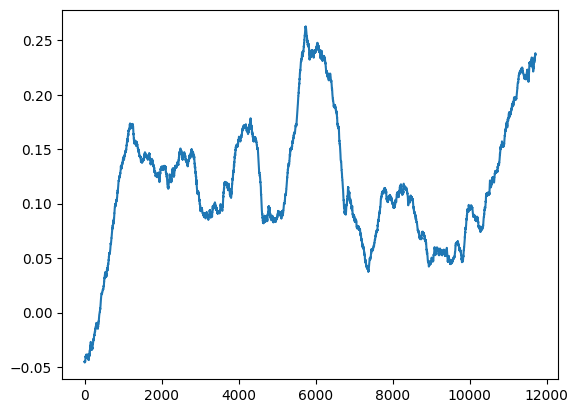

In [60]:
plot_corr(no_uni_20_ep_wiki,spearmanr,11713,500)

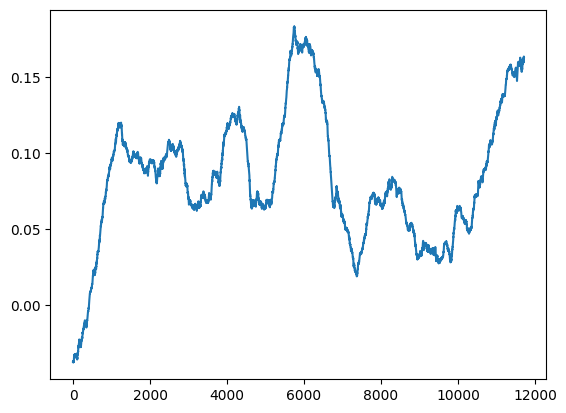

In [61]:
plot_corr(no_uni_20_ep_wiki,kendalltau,11713,500)

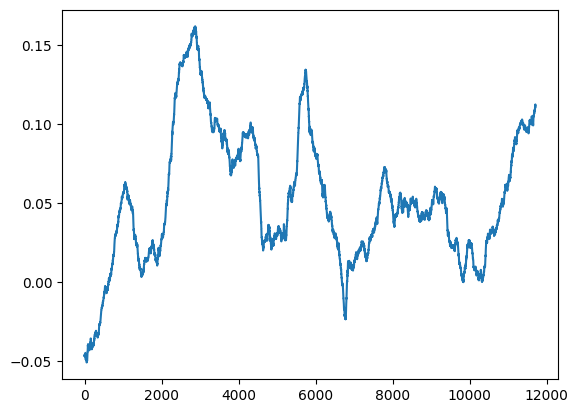

In [62]:
plot_corr(no_uni_20_ep_wiki,pearsonr,11713,500)

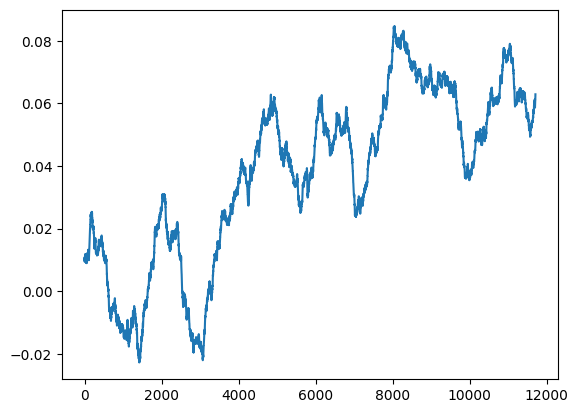

In [65]:
plot_corr(uni_20_ep_wiki,spearmanr,11713,500)

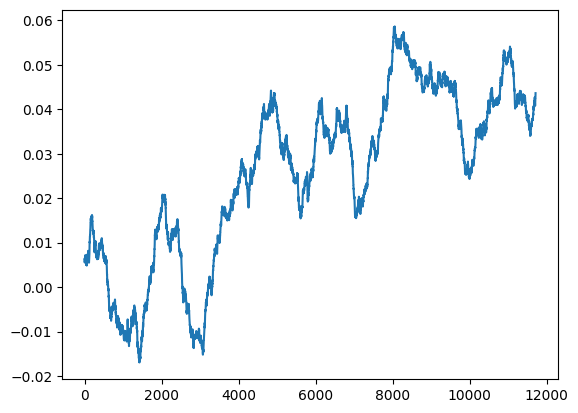

In [66]:
plot_corr(uni_20_ep_wiki,kendalltau,11713,500)

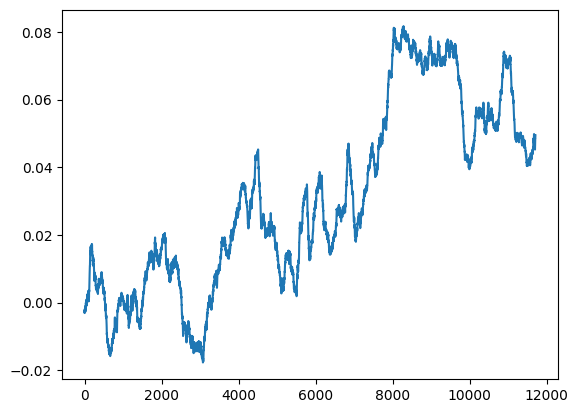

In [67]:
plot_corr(uni_20_ep_wiki,pearsonr,11713,500)